# **Recap of [Lesson 7](https://colab.research.google.com/drive/1LokUcM5YSazdq5jfbkop-Z5rmP-39y4r#forceEdit=true&sandboxMode=true) 👩‍💻🚀**

1. Learned what is a schema.
2. Explored schema settings and components.
3. Learned how to retrieve dlt pipeline schema.
4. Learned how to adjust schema.

---

# **Understanding Pipeline Metadata and State** 👻📄

**Here, you will learn or brush up on:**
- What's pipeline metadata
- Exploring pipeline metadata from load info
- Exploring pipeline metadate from trace
- Exploring pipeline metadata from state

---
##  **Pipeline Metadata**


Metadata is basically data about data.

Pipeline Metadata is data about your data pipeline. This can be useful if you want to know things like:

- When your pipeline first ran
- When your pipeline last ran
- Information about your source or destination
- Processing time
- Or information that you yourself may want to add to the metadata
- And much more!


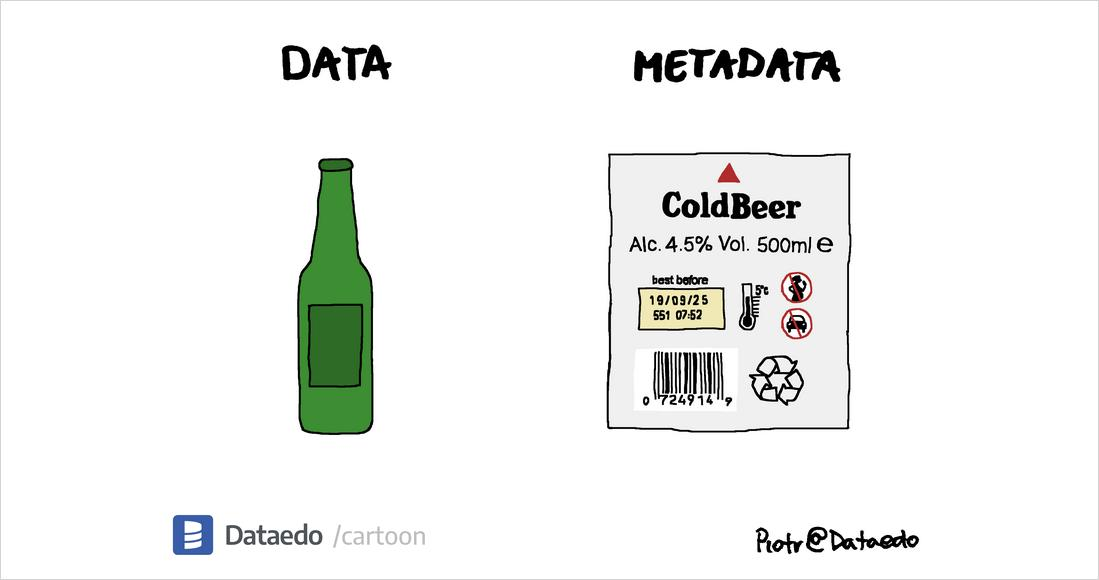

 `dlt` allows you to be able to view all this metadata through various options!

This notebook will walk you through those options. Namely:

- Load info
- Trace
- State

Let's load some GitHub data to DuckDB to inspect the pipeline metadata in different ways. First we need to install dlt with DuckDB:

In [1]:
%%capture
!pip install "dlt[duckdb]"

Define a dlt resource that fetches Pull Requests and wrap it in a dlt source:

In [2]:
import dlt
from dlt.sources.helpers import requests
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator

import os
from google.colab import userdata

os.environ["SOURCES__SECRET_KEY"] = userdata.get('SECRET_KEY')


@dlt.source
def github_source(secret_key=dlt.secrets.value):
    client = RESTClient(
            base_url="https://api.github.com",
            auth=BearerTokenAuth(token=secret_key),
            paginator=HeaderLinkPaginator(),
    )

    @dlt.resource
    def github_pulls(cursor_date=dlt.sources.incremental("updated_at", initial_value="2024-12-01")):
        params = {
            "since": cursor_date.last_value,
            "status": "open"
        }
        for page in client.paginate("repos/dlt-hub/dlt/pulls", params=params):
            yield page


    return github_pulls


# define new dlt pipeline
pipeline = dlt.pipeline(
    pipeline_name="github_pipeline",
    destination="duckdb",
    dataset_name="github_data",
)


# run the pipeline with the new resource
load_info = pipeline.run(github_source())
print(load_info)

Pipeline github_pipeline load step completed in 2.80 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data
The duckdb destination used duckdb:////content/github_pipeline.duckdb location to store data
Load package 1741704687.1890485 is LOADED and contains no failed jobs


---
##  **Load info**


`Load Info:` This is a collection of useful information about the recently loaded data. It includes details like the pipeline and dataset name, destination information, and a list of loaded packages with their statuses, file sizes, types, and error messages (if any).

`Load Package:` A load package is a collection of jobs with data for specific tables, generated during each execution of the pipeline. Each package is uniquely identified by a `load_id`.

---
###  **(0) CLI**


From the [`Inspecting & Adjusting Schema`](https://colab.research.google.com/drive/1LokUcM5YSazdq5jfbkop-Z5rmP-39y4r) Colab we've already learned that we can see which schema changes a load package has introduced with the command:

```
dlt pipeline -v <pipeline_name> load-package
```

The verbose flag only accounts for the schema changes, so if we run it without the flag, we will still see the most recent load package info:

In [3]:
!dlt pipeline github_pipeline load-package

Found pipeline github_pipeline in /var/dlt/pipelines
Package 1741704687.1890485 found in /var/dlt/pipelines/github_pipeline/load/loaded/1741704687.1890485
The package with load id 1741704687.1890485 for schema github_source is in LOADED state. It updated schema for 9 tables. The package was LOADED at 2025-03-11 14:51:32.357576+00:00.
Jobs details:
Job: github_pulls__requested_reviewers.2a9a98d136.insert_values, table: github_pulls__requested_reviewers in completed_jobs. File type: insert_values, size: 889B. Started on: 2025-03-11 14:51:29.444387+00:00 and completed in 2.91 seconds.
Job: github_pulls__base__repo__topics.4ae04eb01c.insert_values, table: github_pulls__base__repo__topics in completed_jobs. File type: insert_values, size: 4.1K. Started on: 2025-03-11 14:51:29.441387+00:00 and completed in 2.92 seconds.
Job: github_pulls__assignees.9c5640f8e8.insert_values, table: github_pulls__assignees in completed_jobs. File type: insert_values, size: 1.2K. Started on: 2025-03-11 14:51:29

The `load_id` of a particular package is added to the top data tables (parent tables) and to the special `_dlt_loads` table with a status of 0 when the load process is fully completed. The `_dlt_loads` table tracks complete loads and allows chaining transformations on top of them.

We can also see load package info with a specific load id:

In [4]:
!dlt pipeline github_pipeline load-package 1741348101.3398592

Found pipeline github_pipeline in /var/dlt/pipelines
Package with load id 1741348101.3398592 could not be found
NOTE: Please refer to our docs at 'https://dlthub.com/docs/reference/command-line-interface#dlt-pipeline' for further assistance.


---
###  **(0) Python**


From the [`Inspecting & Adjusting Schema`](https://colab.research.google.com/drive/1LokUcM5YSazdq5jfbkop-Z5rmP-39y4r?usp=sharing) Colab we've also learned that a schema can be accessed with:

```python
print(load_info.load_packages[0].schema)
```
Similarly if we drop the schema part, we will just get the load package info:

In [5]:
print(load_info.load_packages[0])

The package with load id 1741704687.1890485 for schema github_source is in LOADED state. It updated schema for 9 tables. The package was LOADED at 2025-03-11 14:51:32.357576+00:00.
Jobs details:
Job: github_pulls__requested_reviewers.2a9a98d136.insert_values, table: github_pulls__requested_reviewers in completed_jobs. File type: insert_values, size: 889B. Started on: 2025-03-11 14:51:29.444387+00:00 and completed in 2.91 seconds.
Job: github_pulls__base__repo__topics.4ae04eb01c.insert_values, table: github_pulls__base__repo__topics in completed_jobs. File type: insert_values, size: 4.1K. Started on: 2025-03-11 14:51:29.441387+00:00 and completed in 2.92 seconds.
Job: github_pulls__assignees.9c5640f8e8.insert_values, table: github_pulls__assignees in completed_jobs. File type: insert_values, size: 1.2K. Started on: 2025-03-11 14:51:29.443387+00:00 and completed in 2.91 seconds.
Job: github_pulls.58b67d027e.insert_values, table: github_pulls in completed_jobs. File type: insert_values, s

which has the following public methods and attributes:

In [6]:
# This code snippet just prints out the public methoda and attributes of the schema object in load info
all_attributes_methods = dir(load_info.load_packages[0])
public_attributes_methods = [attr for attr in all_attributes_methods if not attr.startswith('_')]

print(f"{'Attribute/Method':<50} {'Type':<10}")
print("-" * 40)
for attr in public_attributes_methods:
    attr_value = getattr(load_info.load_packages[0], attr)
    if callable(attr_value):
        print(f"{attr:<50} {'method':<10}")
    else:
        print(f"{attr:<50} {'attribute':<10}")

Attribute/Method                                   Type      
----------------------------------------
asdict                                             method    
asstr                                              method    
completed_at                                       attribute 
count                                              method    
index                                              method    
jobs                                               attribute 
load_id                                            attribute 
package_path                                       attribute 
schema                                             attribute 
schema_hash                                        attribute 
schema_name                                        attribute 
schema_update                                      attribute 
state                                              attribute 


---
##  **Trace**


 `Trace`: A trace is a detailed record of the execution of a pipeline. It provides rich information on the pipeline processing steps: **extract**, **normalize**, and **load**. It also shows the last `load_info`.

---
###  **(0) CLI**


You can access pipeline trace using the command:


```
dlt pipeline <pipeline_name> trace
```

Try on the github issues pipeline:

In [7]:
!dlt pipeline github_pipeline trace

Found pipeline github_pipeline in /var/dlt/pipelines
Run started at 2025-03-11 14:51:26.686003+00:00 and COMPLETED in 7.06 seconds with 4 steps.
Step extract COMPLETED in 1.72 seconds.

Load package 1741704687.1890485 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.60 seconds.
Normalized data for the following tables:
- github_pulls: 23 row(s)
- github_pulls__head__repo__topics: 160 row(s)
- github_pulls__base__repo__topics: 230 row(s)
- github_pulls__assignees: 14 row(s)
- github_pulls__labels: 11 row(s)
- github_pulls__requested_reviewers: 8 row(s)
- _dlt_pipeline_state: 1 row(s)

Load package 1741704687.1890485 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 4.25 seconds.
Pipeline github_pipeline load step completed in 2.80 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data
The duckdb destination used duckdb:////content/github_pi

---
###  **(0) Python**


We can also print out the trace in code:

In [8]:
# print human friendly trace information
print(pipeline.last_trace)

Run started at 2025-03-11 14:51:26.686003+00:00 and COMPLETED in 7.06 seconds with 4 steps.
Step extract COMPLETED in 1.72 seconds.

Load package 1741704687.1890485 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.60 seconds.
Normalized data for the following tables:
- github_pulls: 23 row(s)
- github_pulls__head__repo__topics: 160 row(s)
- github_pulls__base__repo__topics: 230 row(s)
- github_pulls__assignees: 14 row(s)
- github_pulls__labels: 11 row(s)
- github_pulls__requested_reviewers: 8 row(s)
- _dlt_pipeline_state: 1 row(s)

Load package 1741704687.1890485 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 4.25 seconds.
Pipeline github_pipeline load step completed in 2.80 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data
The duckdb destination used duckdb:////content/github_pipeline.duckdb location to store data
Load package 174

Separately receive the extract stage info:

In [9]:
# print human friendly trace information
print(pipeline.last_trace.last_extract_info)


Load package 1741704687.1890485 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs


As well as the normalization stage info with:

In [10]:
# print human friendly normalization information
print(pipeline.last_trace.last_normalize_info)

Normalized data for the following tables:
- github_pulls: 23 row(s)
- github_pulls__head__repo__topics: 160 row(s)
- github_pulls__base__repo__topics: 230 row(s)
- github_pulls__assignees: 14 row(s)
- github_pulls__labels: 11 row(s)
- github_pulls__requested_reviewers: 8 row(s)
- _dlt_pipeline_state: 1 row(s)

Load package 1741704687.1890485 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs


In particular how many rows of data were normalized:

In [11]:
 # access row counts dictionary of normalize info
print(pipeline.last_trace.last_normalize_info.row_counts)

{'github_pulls': 23, 'github_pulls__head__repo__topics': 160, 'github_pulls__base__repo__topics': 230, 'github_pulls__assignees': 14, 'github_pulls__labels': 11, 'github_pulls__requested_reviewers': 8, '_dlt_pipeline_state': 1}


And finally the load stage info:

In [12]:
# print human friendly load information
print(pipeline.last_trace.last_load_info)

Pipeline github_pipeline load step completed in 2.80 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data
The duckdb destination used duckdb:////content/github_pipeline.duckdb location to store data
Load package 1741704687.1890485 is LOADED and contains no failed jobs


---
##  **State**

[`The pipeline state`](https://dlthub.com/docs/general-usage/state) is a Python dictionary that lives alongside your data. You can store values in it during a pipeline run, and then retrieve them in the next pipeline run. It's used for tasks like preserving the "last value" or similar loading checkpoints, and it gets committed atomically with the data. The state is stored locally in the pipeline working directory and is also stored at the destination for future runs.


**When to use pipeline state**
- dlt uses the state internally to implement last value incremental loading. This use case should cover around 90% of your needs to use the pipeline state.
- Store a list of already requested entities if the list is not much bigger than 100k elements.
- Store large dictionaries of last values if you are not able to implement it with the standard incremental construct.
- Store the custom fields dictionaries, dynamic configurations and other source-scoped state.

**When not to use pipeline state**

Do not use dlt state when it may grow to millions of elements. Do you plan to store modification timestamps of all of your millions of user records? This is probably a bad idea! In that case you could:

- Store the state in dynamo-db, redis etc. taking into the account that if the extract stage fails you'll end with invalid state.
- Use your loaded data as the state. dlt exposes the current pipeline via dlt.current.pipeline() from which you can obtain sqlclient and load the data of interest. In that case try at least to process your user records in batches.

---
###  **(0) CLI**


In [13]:
!dlt pipeline -v github_pipeline info

Attaching to pipeline github_pipeline
Found pipeline github_pipeline in /var/dlt/pipelines
Synchronized state:
_state_version: 1
_state_engine_version: 4
dataset_name: github_data
schema_names: ['github_source']
default_schema_name: github_source
pipeline_name: github_pipeline
destination_type: dlt.destinations.duckdb
destination_name: None
_version_hash: tNgm4DKxXo0tzuxUICHbUarpjDSbprFqm4GGNKDbicM=

sources:
{
  "github_source": {
    "resources": {
      "github_pulls": {
        "incremental": {
          "updated_at": {
            "initial_value": "2024-12-01",
            "last_value": "2025-03-11T14:25:34Z",
            "unique_hashes": [
              "pHwb5Prd5yEv2xevBso5"
            ]
          }
        }
      }
    }
  }
}

Local state:
first_run: False
initial_cwd: /content
_last_extracted_at: 2025-03-11 14:51:28.869496+00:00
_last_extracted_hash: tNgm4DKxXo0tzuxUICHbUarpjDSbprFqm4GGNKDbicM=

Resources in schema: github_source
github_pulls with 6 table(s) and 1 resource 

---
###  **(1) Python**


In [14]:
import json

def read_state(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
        pretty_json = json.dumps(data, indent=4)
        return pretty_json

In [15]:
# stored in your default pipelines folder
print(read_state("/var/dlt/pipelines/github_pipeline/state.json"))

{
    "_state_version": 1,
    "_state_engine_version": 4,
    "_local": {
        "first_run": false,
        "initial_cwd": "/content",
        "_last_extracted_at": "\uf0272025-03-11T14:51:28.869496+00:00",
        "_last_extracted_hash": "tNgm4DKxXo0tzuxUICHbUarpjDSbprFqm4GGNKDbicM="
    },
    "dataset_name": "github_data",
    "schema_names": [
        "github_source"
    ],
    "default_schema_name": "github_source",
    "pipeline_name": "github_pipeline",
    "destination_type": "dlt.destinations.duckdb",
    "destination_name": null,
    "_version_hash": "tNgm4DKxXo0tzuxUICHbUarpjDSbprFqm4GGNKDbicM=",
    "sources": {
        "github_source": {
            "resources": {
                "github_pulls": {
                    "incremental": {
                        "updated_at": {
                            "initial_value": "2024-12-01",
                            "last_value": "2025-03-11T14:25:34Z",
                            "unique_hashes": [
                            

---
###  **Modify State**

The pipeline state is a Python dictionary that lives alongside your data; you can store values in it and, on the next pipeline run, request them back.

---
####  **(0) Resource state**

You can **read** and **write** the state in your resources using:

```python
dlt.current.resource_state().get()
```
and

```python
dlt.current.resource_state().setdefault(key, value)
```

In [16]:
import dlt
from dlt.sources.helpers import requests
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator

import os
from google.colab import userdata

os.environ["SOURCES__SECRET_KEY"] = userdata.get('SECRET_KEY')


@dlt.source
def github_source(secret_key=dlt.secrets.value):
    client = RESTClient(
            base_url="https://api.github.com",
            auth=BearerTokenAuth(token=secret_key),
            paginator=HeaderLinkPaginator(),
    )

    @dlt.resource
    def github_pulls(cursor_date=dlt.sources.incremental("updated_at", initial_value="2024-12-01")):

        # Let's set some custom state information
        dlt.current.resource_state().setdefault("new_key", ["first_value", "second_value"]) # <--- new item in the state

        params = {
            "since": cursor_date.last_value,
            "status": "open"
        }
        for page in client.paginate("repos/dlt-hub/dlt/pulls", params=params):
            yield page


    return github_pulls


# define new dlt pipeline
pipeline = dlt.pipeline(
    pipeline_name="github_pipeline",
    destination="duckdb",
    dataset_name="github_data",
)


# run the pipeline with the new resource
load_info = pipeline.run(github_source())
print(load_info)

Pipeline github_pipeline load step completed in 0.12 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data
The duckdb destination used duckdb:////content/github_pipeline.duckdb location to store data
Load package 1741704787.4528093 is LOADED and contains no failed jobs


In [17]:
print(read_state("/var/dlt/pipelines/github_pipeline/state.json"))

{
    "_state_version": 2,
    "_state_engine_version": 4,
    "_local": {
        "first_run": false,
        "initial_cwd": "/content",
        "_last_extracted_at": "\uf0272025-03-11T14:53:08.296430+00:00",
        "_last_extracted_hash": "QrqXUYCkWBhkqCgkNqSY0pNMCvdUNRPDLuNRiEreRF8="
    },
    "dataset_name": "github_data",
    "schema_names": [
        "github_source"
    ],
    "default_schema_name": "github_source",
    "pipeline_name": "github_pipeline",
    "destination_type": "dlt.destinations.duckdb",
    "destination_name": null,
    "_version_hash": "QrqXUYCkWBhkqCgkNqSY0pNMCvdUNRPDLuNRiEreRF8=",
    "sources": {
        "github_source": {
            "resources": {
                "github_pulls": {
                    "incremental": {
                        "updated_at": {
                            "initial_value": "2024-12-01",
                            "last_value": "2025-03-11T14:25:34Z",
                            "unique_hashes": [
                            

In the state you will see the new items:

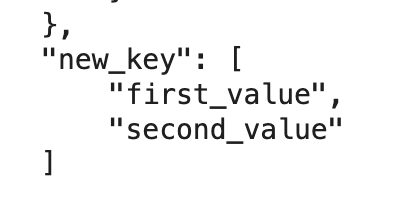

You can modify any item in the state dict:

```python
new_keys = dlt.current.resource_state().setdefault("new_key", ["first_value", "second_value"])

if "something_happend":
    new_keys.append("third_value")

incremental_dict = dlt.current.resource_state().get("incremental")
incremental_dict.update({"second_new_key": "fourth_value"})
```

Full example:

In [18]:
import dlt
from dlt.sources.helpers import requests
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator

import os
from google.colab import userdata

os.environ["SOURCES__SECRET_KEY"] = userdata.get('SECRET_KEY')


@dlt.source
def github_source(secret_key=dlt.secrets.value):
    client = RESTClient(
            base_url="https://api.github.com",
            auth=BearerTokenAuth(token=secret_key),
            paginator=HeaderLinkPaginator(),
    )

    @dlt.resource
    def github_pulls(cursor_date=dlt.sources.incremental("updated_at", initial_value="2024-12-01")):
        # Play with state even more
        new_keys = dlt.current.resource_state().setdefault("new_key", ["first_value", "second_value"])

        if "something_happened":
            new_keys.append("third_value")

        incremental_dict = dlt.current.resource_state().get("incremental")
        incremental_dict.update({"second_new_key": "fourth_value"})

        params = {
            "since": cursor_date.last_value,
            "status": "open"
        }
        for page in client.paginate("repos/dlt-hub/dlt/pulls", params=params):
            yield page


    return github_pulls


# define new dlt pipeline
pipeline = dlt.pipeline(
    pipeline_name="github_pipeline",
    destination="duckdb",
    dataset_name="github_data",
)


# run the pipeline with the new resource
load_info = pipeline.run(github_source())
print(load_info)

Pipeline github_pipeline load step completed in 0.18 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data
The duckdb destination used duckdb:////content/github_pipeline.duckdb location to store data
Load package 1741704797.4870446 is LOADED and contains no failed jobs


In [19]:
print(read_state("/var/dlt/pipelines/github_pipeline/state.json"))

{
    "_state_version": 3,
    "_state_engine_version": 4,
    "_local": {
        "first_run": false,
        "initial_cwd": "/content",
        "_last_extracted_at": "\uf0272025-03-11T14:53:18.674685+00:00",
        "_last_extracted_hash": "NTC3BqGhJTDX9DuNVb6khXYpro9tWsV8iJmoZUlrNVQ="
    },
    "dataset_name": "github_data",
    "schema_names": [
        "github_source"
    ],
    "default_schema_name": "github_source",
    "pipeline_name": "github_pipeline",
    "destination_type": "dlt.destinations.duckdb",
    "destination_name": null,
    "_version_hash": "NTC3BqGhJTDX9DuNVb6khXYpro9tWsV8iJmoZUlrNVQ=",
    "sources": {
        "github_source": {
            "resources": {
                "github_pulls": {
                    "incremental": {
                        "updated_at": {
                            "initial_value": "2024-12-01",
                            "last_value": "2025-03-11T14:25:34Z",
                            "unique_hashes": [
                            

---
####  **(1) Source state**


You can also access the source-scoped state with `dlt.current.source_state()` which can be shared across resources of a particular source and is also available **read-only** in the source-decorated functions. The most common use case for the source-scoped state is to store mapping of custom fields to their displayable names.

Let's read some custom keys from the state:
```python
# Let's read some custom state information
source_new_keys = dlt.current.source_state().get("resources", {}).get("github_pulls", {}).get("new_key")
```
Full example:

In [20]:
import dlt
from dlt.sources.helpers import requests
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator

import os
from google.colab import userdata

os.environ["SOURCES__SECRET_KEY"] = userdata.get('SECRET_KEY')


@dlt.source
def github_source(secret_key=dlt.secrets.value):
    client = RESTClient(
            base_url="https://api.github.com",
            auth=BearerTokenAuth(token=secret_key),
            paginator=HeaderLinkPaginator(),
    )

    @dlt.resource
    def github_pulls(cursor_date=dlt.sources.incremental("updated_at", initial_value="2024-12-01")):
        params = {
            "since": cursor_date.last_value,
            "status": "open"
        }
        for page in client.paginate("repos/dlt-hub/dlt/pulls", params=params):
            yield page

        # Let's read some custom state information
        source_new_keys = dlt.current.source_state().get("resources", {}).get("github_pulls", {}).get("new_key")
        print("My custom values: ", source_new_keys)
    return github_pulls


# define new dlt pipeline
pipeline = dlt.pipeline(
    pipeline_name="github_pipeline",
    destination="duckdb",
    dataset_name="github_data",
)


# run the pipeline with the new resource
load_info = pipeline.run(github_source())
print(load_info)

My custom values:  ['first_value', 'second_value', 'third_value']
Pipeline github_pipeline load step completed in ---
0 load package(s) were loaded to destination duckdb and into dataset None
The duckdb destination used duckdb:////content/github_pipeline.duckdb location to store data


---
###  **Sync State**


What if you run your pipeline on, for example, Airflow where every task gets a clean filesystem and pipeline working directory is always deleted?

**dlt loads** your **state** into the destination **together** with all other **data** and when faced with a clean start, it will try to restore state from the destination.

The remote state is identified by pipeline name, the destination location (as given by the credentials) and destination dataset. To re-use **the same state**, use **the same pipeline name** and destination.

The state is stored in the `_dlt_pipeline_state` table at the destination and contains information about the pipeline, pipeline run (that the state belongs to) and state blob.

dlt has `dlt pipeline <pipeline name> sync` command where you can request the state back from that table.

💡 If you can keep the pipeline working directory across the runs, you can disable the state sync by setting `restore_from_destination=false` i.e. in your `config.toml`.

In [21]:
import duckdb
from google.colab import data_table
data_table.enable_dataframe_formatter()

# a database 'chess_pipeline.duckdb' was created in working directory so just connect to it
conn = duckdb.connect(f"{pipeline.pipeline_name}.duckdb")
conn.sql(f"SET search_path = '{pipeline.dataset_name}'")
stats_table = conn.sql("SELECT * FROM _dlt_pipeline_state").df()
display(stats_table)

,version,engine_version,pipeline_name,state,created_at,version_hash,_dlt_load_id,_dlt_id
0,1,4,github_pipeline,eNplUdFOgzAU/Zc+wwIMXkh80elmFhcTXWI0pilwHdVSuv...,2025-03-11 14:51:28.823620+00:00,tNgm4DKxXo0tzuxUICHbUarpjDSbprFqm4GGNKDbicM=,1741704687.1890485,quOFArvy/8q+bQ
1,2,4,github_pipeline,eNplkV9PwjAUxb9LnzeyjS0xS3wBMT7ogihRNKQp64U1K9...,2025-03-11 14:53:08.260753+00:00,QrqXUYCkWBhkqCgkNqSY0pNMCvdUNRPDLuNRiEreRF8=,1741704787.4528093,oi7EnfFls+hLkg
2,3,4,github_pipeline,eNplUV1PwjAU/S99HoR9GVniC2I0PBBNEBFCmm67sIauG+...,2025-03-11 14:53:18.597161+00:00,NTC3BqGhJTDX9DuNVb6khXYpro9tWsV8iJmoZUlrNVQ=,1741704797.4870446,EMtMjnDs1fnnUw


Column "state" is compressed json dictionary.

|index|version|engine\_version|pipeline\_name|state|created\_at|version\_hash|\_dlt\_load\_id|\_dlt\_id|
|---|---|---|---|---|---|---|---|---|
|0|1|4|github\_pipeline|eNplkN....6+/m/QA7mbNc|2025-03-10 14:02:34\.340458+00:00|pnp+9AIA5jAGx5LKon6zWmPnfYVb10ROa5aIKjv9O0I=|1741615353\.5473728|FOzn5XuSZ/y/BQ|

In [ ]:
!dlt --non-interactive pipeline github_pipeline sync

---
###  **Reset State**


**To fully reset the state:**

Drop the destination dataset to fully reset the pipeline.
Set the `dev_mode` flag when creating pipeline.
Use the `dlt pipeline drop --drop-all` command to drop state and tables for a given schema name.

**To partially reset the state:**

Use the `dlt pipeline drop <resource_name>` command to drop state and tables for a given resource.
Use the `dlt pipeline drop --state-paths` command to reset the state at given path without touching the tables and data.

**Example for partial reset:**

>  in an ipynb environment, when the duckdb connection we opened is not yet closed -> close the connection before attempting to edit the pipeline through the CLI

In [22]:
conn.close()

In [23]:
!yes | dlt pipeline github_pipeline drop github_pulls

Found pipeline github_pipeline in /var/dlt/pipelines
About to drop the following data in dataset github_data in destination duckdb:
Selected schema: github_source
Selected resource(s): ['github_pulls']
Table(s) to drop: ['github_pulls__requested_reviewers', 'github_pulls__labels', 'github_pulls__assignees', 'github_pulls__base__repo__topics', 'github_pulls__head__repo__topics', 'github_pulls']
	with data in destination: ['github_pulls__requested_reviewers', 'github_pulls__labels', 'github_pulls__assignees', 'github_pulls__base__repo__topics', 'github_pulls__head__repo__topics', 'github_pulls']
Resource(s) state to reset: ['github_pulls']
Source state path(s) to reset: []
Do you want to apply these changes? [y/N]: 

In [24]:
!dlt pipeline -v github_pipeline info

Attaching to pipeline github_pipeline
Found pipeline github_pipeline in /var/dlt/pipelines
Synchronized state:
_state_version: 4
_state_engine_version: 4
dataset_name: github_data
schema_names: ['github_source']
default_schema_name: github_source
pipeline_name: github_pipeline
destination_type: dlt.destinations.duckdb
destination_name: None
_version_hash: C8ApFLpFTHccBo6werVQmuyQaaNnk+wmjH0//Hbn8GY=

sources:
{
  "github_source": {
    "resources": {}
  }
}

Local state:
first_run: False
initial_cwd: /content

Resources in schema: github_source

Working dir content:
Has 4 completed load packages with following load ids:
1741704687.1890485
1741704787.4528093
1741704797.4870446
1741704841.5563667

Pipeline has last run trace. Use 'dlt pipeline github_pipeline trace' to inspect 


🎊🎊🎊 That is actually it! We hope you enjoyed this course and learned more about dlt! 🎊🎊🎊

Please share your feedback with us: [Feedback Google Form](https://forms.gle/1NYrGcRj5gLQ4WDt8) 🌼